# Decision Tree

# Imports

Necessary imports 

In [1]:
# Imports necessary imports
import numpy as np
import pandas as pd
import imblearn
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
from sklearn.metrics import confusion_matrix, classification_report

# Get dataset
df = pd.read_csv('telecom_churn.csv')

# Remove the features MonthlyCharge and DataUsage from dataset
df_features = df.drop(["MonthlyCharge", "DataUsage"], axis=1)

In [2]:
# Split dataset
y = df_features.Churn
X = df_features.drop("Churn", axis=1)

# Create training set and test set from X and y, with a 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=5)
df_features.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,CustServCalls,DayMins,DayCalls,OverageFee,RoamMins
0,0,128,1,1,1,265.1,110,9.87,10.0
1,0,107,1,1,1,161.6,123,9.78,13.7
2,0,137,1,0,0,243.4,114,6.06,12.2
3,0,84,0,0,2,299.4,71,3.10,6.6
4,0,75,0,0,3,166.7,113,7.42,10.1


In [3]:
# Create decision treee classifer
dtc = DecisionTreeClassifier(random_state=5)

# Train classifer with training set
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=5)

In [4]:
print(classification_report(y_test, dtc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       575
           1       0.61      0.74      0.67        92

    accuracy                           0.90       667
   macro avg       0.78      0.83      0.81       667
weighted avg       0.91      0.90      0.90       667



In [5]:
def create_confusion_matrix(dtc, y_test, X_test, path):
    confusion_tree=confusion_matrix(y_test, dtc.predict(X_test))
    print("\nconfusion matrix for tree(max_depth 4) after upsamling:\n{}".format(confusion_tree))

    group_names = ["True Negative","False Positive","False Negative","True Positive"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_tree.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         confusion_tree.flatten()/np.sum(confusion_tree)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns_plot = sns.heatmap(confusion_tree, annot=labels, fmt="", cmap='Blues')
    sns_plot.set_title("Confusion matrix")
    sns_plot.set_xlabel("Predicted")
    sns_plot.set_ylabel("Actual")
    sns_plot.figure.savefig(path)


confusion matrix for tree(max_depth 4) after upsamling:
[[532  43]
 [ 24  68]]


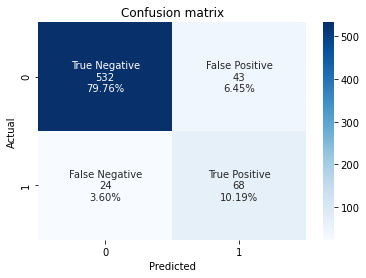

In [6]:
create_confusion_matrix(dtc, y_test, X_test, "images/dt/confusion_matrix_original.jpg")

# Tuning Hyperparameters

In [7]:
# KFold cross-validation

cv_method = KFold(n_splits=10, shuffle=True, random_state=5)

In [8]:
def tuning_hyperparameters(cv_method=cv_method):
    tune_tree = DecisionTreeClassifier(random_state=5)

    dt_parameters = {'max_depth': range(1,11),
                   'max_features': range(4,19)}

    dt_gridSearch = GridSearchCV(tune_tree, dt_parameters,
    cv=cv_method, n_jobs=-1,
    verbose=True)

    dt_gridSearch.fit(X_train, y_train);
    return dt_gridSearch

In [9]:
# GrdiSearch for tuning hyperparameters

gridSearch_tuned = tuning_hyperparameters()
best_tuned_clf = gridSearch_tuned.best_estimator_
gridSearch_tuned.best_estimator_

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 970 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.6s finished


DecisionTreeClassifier(max_depth=7, max_features=6, random_state=5)

In [10]:
# Print classification report

print(classification_report(y_test, best_tuned_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       575
           1       0.87      0.63      0.73        92

    accuracy                           0.94       667
   macro avg       0.90      0.81      0.85       667
weighted avg       0.93      0.94      0.93       667




confusion matrix for tree(max_depth 4) after upsamling:
[[566   9]
 [ 34  58]]


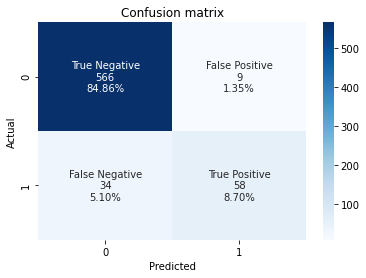

In [11]:
# Visualize confusion matrix

create_confusion_matrix(best_tuned_clf, y_test, X_test, "images/dt/confusion_matrix_original_tuned.jpg")

# SMOTETomek Resampling

In [12]:
# Methods for resampling
def resample_SMOTE(X_train, y_train, random_state):
    smt = SMOTETomek(sampling_strategy=1.0, random_state=random_state)
    X_smt, y_smt = smt.fit_sample(X, y)

    return X_smt, y_smt

In [13]:
# Create training set and test set from X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=5)

# Create resampled training set
X_train, y_train = resample_SMOTE(X_train, y_train, 5)

In [14]:
# Declare decision tree classifer
dtc = DecisionTreeClassifier(random_state=5)

# Train classifer with training set
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=5)

In [15]:
# Print classification report

print(classification_report(y_test, dtc.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       575
           1       0.98      1.00      0.99        92

    accuracy                           1.00       667
   macro avg       0.99      1.00      0.99       667
weighted avg       1.00      1.00      1.00       667




confusion matrix for tree(max_depth 4) after upsamling:
[[573   2]
 [  0  92]]


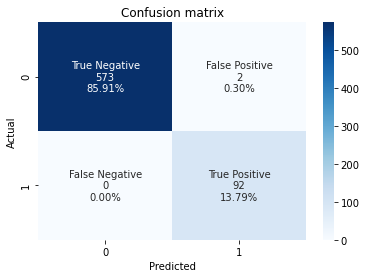

In [16]:
# Confusion matrix for resampled dataset

create_confusion_matrix(dtc, y_test, X_test, "images/dt/confusion_matrix_dt.jpg")

# Tunining Hyperparameters with resampled dataset

In [17]:
# KFold cross_validation 

cv_method = KFold(n_splits=10, shuffle=True, random_state=5)

In [18]:
# GrdiSearch for tuning hyperparameters

gridSearch_tuned = tuning_hyperparameters()
best_tuned_clf = gridSearch_tuned.best_estimator_
gridSearch_tuned.best_estimator_

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    1.5s finished


DecisionTreeClassifier(max_depth=8, max_features=8, random_state=5)

In [19]:
# Print classification report

print(classification_report(y_test, best_tuned_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       575
           1       0.80      0.91      0.85        92

    accuracy                           0.96       667
   macro avg       0.89      0.94      0.91       667
weighted avg       0.96      0.96      0.96       667




confusion matrix for tree(max_depth 4) after upsamling:
[[554  21]
 [  8  84]]


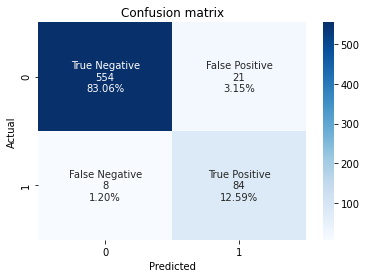

In [20]:
create_confusion_matrix(best_tuned_clf, y_test, X_test, "images/dt/confusion_matrix_dt_tuned.jpg")